3/28-8/14/2023 Melody

Gesture dictionary: https://docs.google.com/spreadsheets/d/1sbqk3yhHmSTHwnPzFaysUrvq9zIcPBIviqJx4oQVA1s/edit#gid=0

# Overall Workflow
8/6/2023

### 1. Segment Anything -- to retain only the human in each frame

[Google Colab](https://colab.research.google.com/drive/1VyTkcKwy17Bg6Eblc0wtV9GwJo3oEjU6)
To extract only the human figure from the background and devices.

**Problems Remain**: A fixed coordinate may not always land on the human, hence the human might be cropped out in some of the frames.


### 2. Image Inpainting/completion

**This** https://github.com/wyhuai/DDNM

[Deep Fill v2](https://github.com/nipponjo/deepfillv2-pytorch)

[List of papers](https://paperswithcode.com/task/image-inpainting)

1. [Free-Form Image Inpainting with Gated Convolution](https://arxiv.org/pdf/1806.03589v2.pdf) Not very relatable.

Github: https://github.com/JiahuiYu/generative_inpainting


2. [JPGNet: Joint Predictive Filtering and Generative Network for Image Inpainting](https://arxiv.org/pdf/2107.04281v3.pdf) Quite the thing, code composition confusing.

Github: https://github.com/tsingqguo/jpgnet

3. [Generative Image Inpainting with Contextual Attention](https://arxiv.org/pdf/1801.07892v2.pdf)

Github: https://github.com/JiahuiYu/generative_inpainting

- 3D: [ProxyFormer: Proxy Alignment Assisted Point Cloud Completion with Missing Part Sensitive Transformer](https://arxiv.org/pdf/2302.14435v1.pdf)

### 3. MoveNet  -- to extract the key points of the human

[Google Colab](https://colab.research.google.com/drive/1m4LIPi7sLh-81YUWZ7iBowq0cc7omL2K)
To extract the 2D coordinates of the human, key points include:

**Problems**: 
- Since some parts of the human might be missing, the pinpoints might not be accurate (especially with devices blocked in the foreground).
- The human parts might be disconnected due to 

--> (any current paper on this?)

--> When identifying abnormal movement, take the average of the former frame and latter frame.

--> Constrain the length of the limb (e.g. upper arm), if changes to much, do as the above step.



## 0. Install and Import Dependencies
- MediaPipe

`!pip3 install mediapipe opencv-python`

- OpenCV

`!pip3 install nb_helpers`

In [1]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import Video
import nb_helpers
import pandas as pd
import glob
import numpy.linalg as LA
import os
import math

import json

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh
poselandmarks_list = mp.solutions.pose.PoseLandmark

## 1. General functions

[link](https://github.com/tensorflow/tfjs-models/blob/master/pose-detection/README.md#pose-estimation)

<img src="https://camo.githubusercontent.com/b8a385301ca6b034d5f4807505e528b4512a0aa78507dec9ebafcc829b9556be/68747470733a2f2f73746f726167652e676f6f676c65617069732e636f6d2f6d6f76656e65742f636f636f2d6b6579706f696e74732d3530302e706e67" width="350">

    0: left_shoulder_x 
    1: left_shoulder_y 
    2: right_shoulder_x
    3: right_shoulder_y
    4: left_elbow_x
    5: left_elbow_y
    6: right_elbow_x
    7: right_elbow_y
    8: left_wrist_x
    9: left_wrist_y
    10: right_wrist_x
    11: right_wrist_y
    12: left_hip_x
    13: left_hip_y
    14: right_hip_x
    15: right_hip_y
    16: left_knee_x
    17: left_knee_y
    18: right_knee_x
    19: right_knee_y
    20: left_ankle_x
    21: left_ankle_y
    22: right_ankle_x
    23: right_ankle_y

**Input JSON File**

`[{'left_shoulder_x': 0.3179936707019806, 'left_shoulder_y': 0.5114062428474426}, {'right_shoulder_x': 0.33679449558258057, 'right_shoulder_y': 0.34741756319999695}, {'left_elbow_x': 0.4350297152996063, 'left_elbow_y': 0.6411520838737488}, {'right_elbow_x': 0.43745386600494385, 'right_elbow_y': 0.44536760449409485}, {'left_wrist_x': 0.549847424030304, 'left_wrist_y': 0.6477686762809753}, {'right_wrist_x': 0.5335683226585388, 'right_wrist_y': 0.4491853713989258}, {'left_hip_x': 0.5250557661056519, 'left_hip_y': 0.6010480523109436}, {'right_hip_x': 0.5312585830688477, 'right_hip_y': 0.4901477098464966}, {'left_knee_x': 0.6984337568283081, 'left_knee_y': 0.610877275466919}, {'right_knee_x': 0.6926252245903015, 'right_knee_y': 0.49222883582115173}, {'left_ankle_x': 0.8516842722892761, 'left_ankle_y': 0.6464917659759521}, {'right_ankle_x': 0.8261151313781738, 'right_ankle_y': 0.5422400236129761},...]`

In [3]:
file_path = 'output/018_barbell_curls4/018_barbell_curls4_SAM_MoveNet.json'

In [4]:
# Melody 8/8/2023 rewrite
# Process MoveNet generated JSON files
def read_movenet_json_file(file_path):

    # 1. Load the json file generated by MoveNet, parsed_data is a list of dictionaries
    # with each dictionary as 
    with open(file_path) as data:
        all_data = data.read()

    parsed_data = json.loads(all_data)

    
    # 2. Create a pandas dataframe with each row representing a frame of the video.
    list_by_keypoints = []
    i = 0

    while i < (len(parsed_data) / 12):
        frame_dict = []
        
        for j in range(0, 12):
            frame_dict.append(parsed_data[i * 12 + j])
            
        list_by_keypoints.append(frame_dict)
        i += 1
         

    # 3. Add header row to dataframe
    '''
          | LShoulder_x | LShoulder_y | RAnkle_y
    ------------------------------------------------------------------------------------------
    row 0 |   0.317     |   0.511     |   ...
    ------------------------------------------------------------------------------------------
    row 1 |    ...      |    ...      |   ...
    ...
    '''
    
    pose_coords = pd.DataFrame(list_by_keypoints, columns = ['left_shoulder_xy', 'right_shoulder_xy', 
                                                            'left_elbow_xy', 'right_elbow_xy',
                                                            'left_wrist_xy', 'right_wrist_xy', 
                                                            'left_hip_xy', 'right_hip_xy', 
                                                            'left_knee_xy', 'right_knee_xy', 
                                                            'left_ankle_xy', 'right_ankle_xy'])


    # 4. Extract the values and add to the corresponding column
    lshoulder_x, lshoulder_y, rshoulder_x, rshoulder_y = ([] for i in range(4))
    lelbow_x, lelbow_y, relbow_x, relbow_y = ([] for i in range(4))
    lwrist_x, lwrist_y, rwrist_x, rwrist_y = ([] for i in range(4))
    lhip_x, lhip_y, rhip_x, rhip_y = ([] for i in range(4))
    lknee_x, lknee_y, rknee_x, rknee_y = ([] for i in range(4))
    lankle_x, lankle_y, rankle_x, rankle_y = ([] for i in range(4))
    
    # Shoulders
    for each_frame in pose_coords['left_shoulder_xy']:
        lshoulder_x.append(each_frame.get('left_shoulder_x'))
        lshoulder_y.append(each_frame.get('left_shoulder_y'))
        
    for each_frame in pose_coords['right_shoulder_xy']:
        rshoulder_x.append(each_frame.get('right_shoulder_x'))
        rshoulder_y.append(each_frame.get('right_shoulder_y'))
        
    # Elbows
    for each_frame in pose_coords['left_elbow_xy']:
        lelbow_x.append(each_frame.get('left_elbow_x'))
        lelbow_y.append(each_frame.get('left_elbow_y'))

    for each_frame in pose_coords['right_elbow_xy']:
        relbow_x.append(each_frame.get('right_elbow_x'))
        relbow_y.append(each_frame.get('right_elbow_y'))
    
    # Wrists
    for each_frame in pose_coords['left_wrist_xy']:
        lwrist_x.append(each_frame.get('left_wrist_x'))
        lwrist_y.append(each_frame.get('left_wrist_y'))

    for each_frame in pose_coords['right_wrist_xy']:
        rwrist_x.append(each_frame.get('right_wrist_x'))
        rwrist_y.append(each_frame.get('right_wrist_y'))
    
    # Hips
    for each_frame in pose_coords['left_hip_xy']: 
        lhip_x.append(each_frame.get('left_hip_x'))
        lhip_y.append(each_frame.get('left_hip_y'))
        
    for each_frame in pose_coords['right_hip_xy']: 
        rhip_x.append(each_frame.get('right_hip_x'))
        rhip_y.append(each_frame.get('right_hip_y'))
    
    # Knees 
    for each_frame in pose_coords['left_knee_xy']: 
        lknee_x.append(each_frame.get('left_knee_x'))
        lknee_y.append(each_frame.get('left_knee_y'))
    
    for each_frame in pose_coords['right_knee_xy']: 
        rknee_x.append(each_frame.get('right_knee_x'))
        rknee_y.append(each_frame.get('right_knee_y'))
    
    # Ankles
    for each_frame in pose_coords['left_ankle_xy']: 
        lankle_x.append(each_frame.get('left_ankle_x'))
        lankle_y.append(each_frame.get('left_ankle_y'))
    
    for each_frame in pose_coords['right_ankle_xy']: 
        rankle_x.append(each_frame.get('right_ankle_x'))
        rankle_y.append(each_frame.get('right_ankle_y'))
    
    
    # Add each of x, y and z coordinates to the dataframe
    pose_coords['LShoulder_X'] = lshoulder_x
    pose_coords['LShoulder_Y'] = lshoulder_y
    
    pose_coords['RShoulder_X'] = rshoulder_x  
    pose_coords['RShoulder_Y'] = rshoulder_y 
    
    pose_coords['LElbow_X'] = lelbow_x
    pose_coords['LElbow_Y'] = lelbow_y
    
    pose_coords['RElbow_X'] = relbow_x
    pose_coords['RElbow_Y'] = relbow_y
    
    pose_coords['LWrist_X'] = lwrist_x
    pose_coords['LWrist_Y'] = lwrist_y
    
    pose_coords['RWrist_X'] = rwrist_x
    pose_coords['RWrist_Y'] = rwrist_y
    
    pose_coords['LHip_X'] = lhip_x
    pose_coords['LHip_Y'] = lhip_y
    
    pose_coords['RHip_X'] = rhip_x 
    pose_coords['RHip_Y'] = rhip_y  
    
    pose_coords['LKnee_X'] = lknee_x
    pose_coords['LKnee_Y'] = lknee_y
    
    pose_coords['RKnee_X'] = rknee_x
    pose_coords['RKnee_Y'] = rknee_y
    
    pose_coords['LAnkle_X'] = lankle_x
    pose_coords['LAnkle_Y'] = lankle_y
    
    pose_coords['RAnkle_X'] = rankle_x  
    pose_coords['RAnkle_Y'] = rankle_y
    
    
    pose_coords = pose_coords.drop(columns = ['left_shoulder_xy', 'right_shoulder_xy', 
                                              'left_elbow_xy', 'right_elbow_xy',
                                              'left_wrist_xy', 'right_wrist_xy', 
                                              'left_hip_xy', 'right_hip_xy', 
                                              'left_knee_xy', 'right_knee_xy', 
                                              'left_ankle_xy', 'right_ankle_xy'])
    
    return pose_coords


# Test the function
pose_coords = read_movenet_json_file(file_path)
pose_coords

,LShoulder_X,LShoulder_Y,RShoulder_X,RShoulder_Y,LElbow_X,LElbow_Y,RElbow_X,RElbow_Y,LWrist_X,LWrist_Y,...,RHip_X,RHip_Y,LKnee_X,LKnee_Y,RKnee_X,RKnee_Y,LAnkle_X,LAnkle_Y,RAnkle_X,RAnkle_Y
0,0.317994,0.511406,0.336794,0.347418,0.435030,0.641152,0.437454,0.445368,0.549847,0.647769,...,0.531259,0.490148,0.698434,0.610877,0.692625,0.492229,0.851684,0.646492,0.826115,0.542240
1,0.326701,0.521034,0.343285,0.349556,0.449628,0.645923,0.438546,0.446151,0.562267,0.626327,...,0.531256,0.504349,0.697215,0.603378,0.688352,0.489358,0.859187,0.641774,0.835942,0.549363
2,0.319108,0.529947,0.337623,0.375315,0.438620,0.646342,0.433729,0.455140,0.551085,0.609579,...,0.523161,0.498470,0.692064,0.604551,0.686648,0.489935,0.853995,0.636085,0.824482,0.543683
3,0.315460,0.550209,0.329563,0.384317,0.434913,0.645642,0.428778,0.457372,0.550333,0.601716,...,0.523264,0.504046,0.693003,0.602441,0.684091,0.488670,0.851220,0.640857,0.831473,0.547702
4,0.305735,0.557335,0.321626,0.392229,0.423360,0.662499,0.429083,0.458306,0.530854,0.583181,...,0.520036,0.506391,0.696149,0.609868,0.688253,0.492584,0.855740,0.634442,0.825379,0.550363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.298058,0.590167,0.305134,0.434934,0.426849,0.652344,0.410901,0.450469,0.521581,0.544432,...,0.535568,0.507733,0.700722,0.633664,0.689535,0.518014,0.856337,0.646400,0.824879,0.551113
180,0.296559,0.591037,0.311740,0.429195,0.423711,0.654132,0.419997,0.453639,0.532100,0.553816,...,0.531540,0.507637,0.700569,0.630386,0.692475,0.515711,0.863563,0.648511,0.831973,0.556859
181,0.300281,0.588143,0.312965,0.424043,0.423174,0.648670,0.425492,0.446500,0.533131,0.554274,...,0.525939,0.506243,0.694440,0.623053,0.688507,0.516438,0.858389,0.645751,0.824559,0.555261
182,0.301158,0.578807,0.315116,0.415956,0.429323,0.634695,0.427815,0.452336,0.545319,0.566004,...,0.522183,0.508712,0.695188,0.620871,0.686179,0.513620,0.858762,0.646462,0.823989,0.556856


`two_dim_vectors_angle(...)`

- Parameters: two 2-dimensional vectors' head and tail's x and y coordinates
- Returns: the angle (in degree)

In [5]:
# 8/8/2023

# In some cases, they might share the same tail
# Reference: https://swdevnotes.com/python/2021/math-3d-vectors-dot-product/
# Latest reference: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

""" Returns the unit vector of the vector.  """
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

""" Returns the angle in radians between vectors 'v1' and 'v2' """
def two_dim_vectors_angle(vec1_head_x, vec1_head_y, 
                          vec1_tail_x, vec1_tail_y,
                          vec2_head_x, vec2_head_y,
                          vec2_tail_x, vec2_tail_y):
    # Construct vectors
    # Tails of both vectors are the joint point (e.g. elbow)
    vector_1 = [vec1_head_x - vec1_tail_x, vec1_head_y - vec1_tail_y]
    vector_2 = [vec2_head_x - vec2_tail_x, vec2_head_y - vec2_tail_y]
    
    # Normalize vectors
    v1_u = vector_1 / np.linalg.norm(vector_1)
    v2_u = vector_2 / np.linalg.norm(vector_2)
    
    # Calculate angle
    angle_radian = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
    """Alternatively
    dot_product = np.dot(unit_vec1, unit_vec2)
    angle_radian = np.arccos(dot_product) # Angle in radian
    """
    
    # Convert angle in radian to angle in degree
    angle_degree = angle_radian * 180 / math.pi
    
    return round(angle_degree, 3) # round 3 decimals

# Validate if the function works
# Should return 135
print(two_dim_vectors_angle(1, 1, 
                            0, 0, 
                            -2, 0, 
                            0, 0))

135.0


`get_keyjoint_column(pose_coords, keyjoint_header)`

e.g. `get_keyjoint_column(pose_coords, "LShoulder_X")`

In [6]:
# Melody-8/9/2023
def get_keyjoint_column(pose_coords, keyjoint_header):
    return pose_coords[keyjoint_header]

In [7]:
# Melody-8/9/2023
def plot_curve(x_axis, y_axis):
    plt.plot(x_axis, y_axis)
    plt.show()

In [8]:
# Melody-8/9/2023
def get_length(x1, x2, y1, y2):
    a = (x1, y1)
    b = (x2, y2)
    return math.dist(a, b)

`get_joint_angles(pose_coords)`

- Parameters: the list of x and y coordinates of 12 key points (6 on each side)
- Returns: the angle list by video frame of 8 angles
  - left/right elbows
  - left/right shoulders
  - left/right hips
  - left/right knees

In [9]:
# 8/8/2023
def get_joint_angles(pose_coords):
    
    # To store the list of angles (of left and right) at each point of time (by video frame)
    # wrist <- elbow -> shoulder on the same side
    lelbow_angles = []
    relbow_angles = []
    
    # elbow <- shoulder -> hip on the same side
    lshoulder_angles = [] 
    rshoulder_angles = []
    
    # shoulder <- hip -> knee on the same side
    lhip_angles = []
    rhip_angles = []
    
    # hip <- knee -> ankle on the same side
    lknee_angles = []
    rknee_angles = []
    
    # Iterate through each video frame
    for index, row in pose_coords.iterrows():
    
        # Upper body
        lwrist_x = row['LWrist_X']
        lwrist_y = row['LWrist_Y']
        
        lelbow_x = row['LElbow_X']
        lelbow_y = row['LElbow_Y']
        
        lshoulder_x = row['LShoulder_X']
        lshoulder_y = row['LShoulder_Y']
        
        rwrist_x = row['RWrist_X']
        rwrist_y = row['RWrist_Y']

        relbow_x = row['RElbow_X']
        relbow_y = row['RElbow_Y']

        rshoulder_x = row['RShoulder_X']
        rshoulder_y = row['RShoulder_Y']

        # Lower body
        lhip_x = row['LHip_X']
        lhip_y = row['LHip_Y']
        
        lknee_x = row['LKnee_X']
        lknee_y = row['LKnee_Y']
        
        lankle_x = row['LAnkle_X']
        lankle_y = row['LAnkle_Y']
        
        rhip_x = row['RHip_X']
        rhip_y = row['RHip_Y']
        
        rknee_x = row['RKnee_X']
        rknee_y = row['RKnee_Y']
        
        rankle_x = row['RAnkle_X']
        rankle_y = row['RAnkle_Y']

        # Save the angles to lists
        # vector1_head (x, y, z), vector1_tail (x, y, z), vector2_head (x, y, z), vector2_tail (x, y, z)

        # wrist <- elbow -> shoulder
        lelbow_angles.append(two_dim_vectors_angle(lwrist_x, lwrist_y,
                                                   lelbow_x, lelbow_y,
                                                   lshoulder_x, lshoulder_y,
                                                   lelbow_x, lelbow_y))

        relbow_angles.append(two_dim_vectors_angle(rwrist_x, rwrist_y,
                                                   relbow_x, relbow_y, 
                                                   rshoulder_x, rshoulder_y,
                                                   relbow_x, relbow_y))

        # elbow <- shoulder -> hip
        lshoulder_angles.append(two_dim_vectors_angle(lelbow_x, lelbow_y,
                                                      lshoulder_x, lshoulder_y,
                                                      lhip_x, lhip_y,
                                                      lshoulder_x, lshoulder_y))

        rshoulder_angles.append(two_dim_vectors_angle(relbow_x, relbow_y, 
                                                      rshoulder_x, rshoulder_y, 
                                                      rhip_x, rhip_y, 
                                                      rshoulder_x, rshoulder_y))

        # shoulder <- hip -> knee
        lhip_angles.append(two_dim_vectors_angle(lshoulder_x, lshoulder_y,
                                                 lhip_x, lhip_y, 
                                                 lknee_x, lknee_y,
                                                 lhip_x, lhip_y))

        rhip_angles.append(two_dim_vectors_angle(rshoulder_x, rshoulder_y,
                                                 rhip_x, rhip_y,
                                                 rknee_x, rknee_y, 
                                                 rhip_x, rhip_y))

        # hip <- knee -> ankle
        lknee_angles.append(two_dim_vectors_angle(lhip_x, lhip_y,
                                                  lknee_x, lknee_y,
                                                  lankle_x, lankle_y,
                                                  lknee_x, lknee_y))

        rknee_angles.append(two_dim_vectors_angle(rhip_x, rhip_y, 
                                                  rknee_x, rknee_y, 
                                                  rankle_x, rankle_y,  
                                                  rknee_x, rknee_y))
    
    return lelbow_angles, relbow_angles, lshoulder_angles, rshoulder_angles, lhip_angles, rhip_angles, lknee_angles, rknee_angles

`normalization`

If the change of degree of one frame and its previous frame exceeds 20 degrees --> abnormal

Record the previous degree (last normal degree), find until a degree with a difference less than 20 degree (first normal degree). Draw a straight line in between to replace the abnormal ones.

In [10]:
# Melody 8/14/2023

def normalization_key_indices(original_coords):
    
    key_indices = []
    key_index = []
    last_end = 0
    
    for curr_idx in range(1, len(original_coords) - 1):  
        
        if len(key_index) == 0 and abs(original_coords[curr_idx] - original_coords[curr_idx - 1]) > 20:
            if curr_idx <= last_end:
                continue
            key_index.append(curr_idx - 1)
        
        if len(key_index) > 0 and abs(original_coords[curr_idx] - original_coords[key_index[0]]) <= 20:
            key_index.append(curr_idx + 1)
            key_indices.append(key_index)
            last_end = curr_idx + 1
            key_index = []

    return key_indices

In [11]:
# Melody 8/14/2023

def normalization(original_coords):
    
    normalized_coords = original_coords.copy()
    key_indices = normalization_key_indices(original_coords)

    for keys in key_indices:
        start_idx = keys[0]
        end_idx = keys[1]

        # Normalize the data in between last_norm_idx and first_norm_idx
        normalized_degrees = np.linspace(normalized_coords[start_idx], normalized_coords[end_idx], 
                    end_idx - start_idx - 1)
        
        normalized_coords[start_idx + 1 : end_idx] = normalized_degrees
        
    return normalized_coords

In [72]:
# 8/9/2023
# If the movement exceeds a certain degree --> considered bend/extend
def get_bend_extend_frames(langles, rangles, degree):
    
    lside_turning_points = {}
    rside_turning_points = {}

    # Consider neither bending or extending from both sides
    if ((max(langles) - min(langles)) <= degree) and ((max(rangles) - min(rangles)) <= degree):
        return lside_turning_points, rside_turning_points
    
    # Consider there're bending or extending in at least one side
    lside_bend = []
    lside_extend = []

    # Go from frame to frame, find the next point with the greatest difference
    # If difference <= 20 --> staying still
    # Else
    #     If difference is positive --> angle degrees going down --> bending
    #     If difference is negative --> angle degrees going up --> extending
    curr_frame = 0
    curr_angle = langles[curr_frame]
    max_diff = 0

    interval = []
    interval.append(curr_frame)

    for i in range(1, len(langles) - 2):
        next_angle = langles[i]
        diff = abs(curr_angle - next_angle)

        if diff > max_diff and i < len(langles) - 3:
            max_diff = diff

        else:
            # If the turning point is within 20 degrees' of change with the starting point
            # Or if the degree keeps decreasing, but not reaching the local min
            if (diff < degree) or ((curr_angle - next_angle < 0) and (next_angle < langles[i+2])):
                continue
            elif (diff < degree) or ((curr_angle - next_angle > 0) and (next_angle > langles[i+2])):
                continue
            else:
                interval.append(i - 1)
                # Check if it is bending or extending
                if curr_angle - next_angle > 0: # bending
                    lside_bend.append(interval)
                else: # extending
                    lside_extend.append(interval)

                curr_angle = langles[i - 1]
                interval = []
                interval.append(i - 1)
                max_diff = 0

    # Another condition is that it keeps growing/decreasing, but reaching the end
    if abs(curr_angle - langles[-1]) > degree:
        interval = []
        interval.append(curr_frame)
        interval.append(len(langles)-1)
        if curr_angle - langles[-1] > 0: # bending
            lside_bend.append(interval)
        else:  # extending
            lside_extend.append(interval)

    lside_turning_points['bend'] = lside_bend
    lside_turning_points['extend'] = lside_extend


    # Check the RIGHT side    
    if (max(rangles) - min(rangles)) > degree:
        rside_bend = []
        rside_extend = []

        # Go from frame to frame, find the next point with the greatest difference
        # If difference <= 20 --> staying still
        # Else
        #     If difference is positive --> angle degrees going down --> bending
        #     If difference is negative --> angle degrees going up --> extending
        curr_frame = 0
        curr_angle = rangles[curr_frame]
        max_diff = 0

        interval = []
        interval.append(curr_frame)

        for i in range(1, len(rangles) - 2):
            next_angle = rangles[i]
            diff = abs(curr_angle - next_angle)

            if diff > max_diff:
                max_diff = diff

            else:
                # If the turning point is within 20 degrees' of change with the starting point
                # Or if the degree keeps decreasing, but not reaching the local min
                if (diff < degree) or ((curr_angle - next_angle < 0) and (next_angle < rangles[i+2])):
                    continue
                elif (diff < degree) or ((curr_angle - next_angle > 0) and (next_angle > rangles[i+2])):
                    continue
                else:
                    interval.append(i - 1)
                    # Check if it is bending or extending
                    if curr_angle - next_angle > 0: # bending
                        rside_bend.append(interval)
                    else: # extending
                        rside_extend.append(interval)

                    curr_angle = rangles[i - 1]
                    interval = []
                    interval.append(i - 1)
                    max_diff = 0

        # Another condition is that it keeps growing/decreasing, but reaching the end
        if abs(curr_angle - rangles[-1]) > degree:
            interval = []
            interval.append(curr_frame)
            interval.append(len(rangles)-1)
            if curr_angle - rangles[-1] > 0: # bending
                rside_bend.append(interval)
            else:  # extending
                rside_extend.append(interval)

        rside_turning_points['bend'] = rside_bend
        rside_turning_points['extend'] = rside_extend

    lside_turning_points = noise_reduction(lside_turning_points)
    rside_turning_points = noise_reduction(rside_turning_points)
    
    return lside_turning_points, rside_turning_points

`noise_reduction`

To identify if the curve indicates movement by checking if the starting and ending indices is less than or equal to 20.

In [53]:
# Melody 8/18/2023
def noise_reduction(bend_extend_dict):
    
    new_bend = []
    new_extend = []
    new_dict = {}
    
    for start_end in bend_extend_dict['bend']:
        if start_end[1] - start_end[0] > 20:
            new_bend.append(start_end)
    
    for start_end in bend_extend_dict['extend']:
        if start_end[1] - start_end[0] > 20:
            new_extend.append(start_end)
    
    new_dict['bend'] = new_bend
    new_dict['extend'] = new_extend
    
    return new_dict

## 2. Correct the curves (test)

In [13]:
lelbow_angles, relbow_angles, lshoulder_angles, rshoulder_angles, lhip_angles, rhip_angles, lknee_angles, rknee_angles = get_joint_angles(pose_coords) 

### Left elbow

[color reference](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

Text(0, 0.5, 'angle')

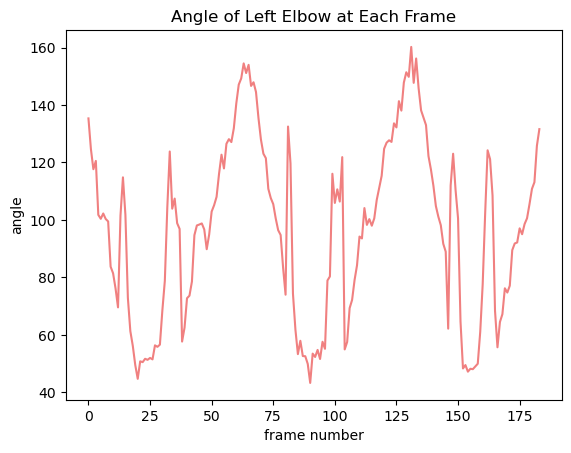

In [14]:
x_axis = range(len(lelbow_angles))
plt.plot(x_axis, lelbow_angles, color = "lightcoral")

plt.title('Angle of Left Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

In [15]:
normalized_coords = normalization(lelbow_angles)

[[12, 17], [31, 38], [80, 84], [96, 105], [145, 151], [160, 166]]


Text(0, 0.5, 'angle')

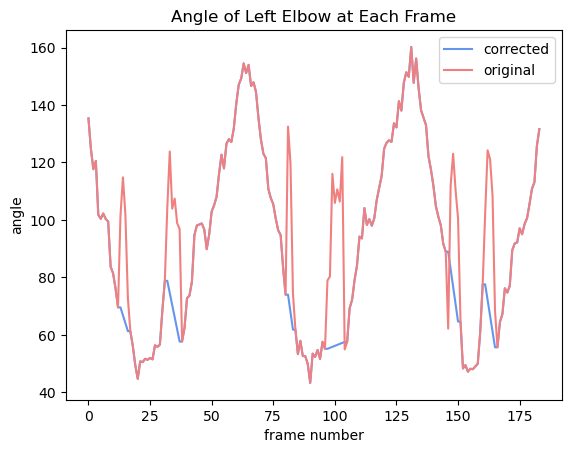

In [16]:
# 8/14/2023
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.plot(x_axis, lelbow_angles, color = "lightcoral")
plt.legend(['corrected', 'original'])

plt.title('Angle of Left Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

Text(0, 0.5, 'angle')

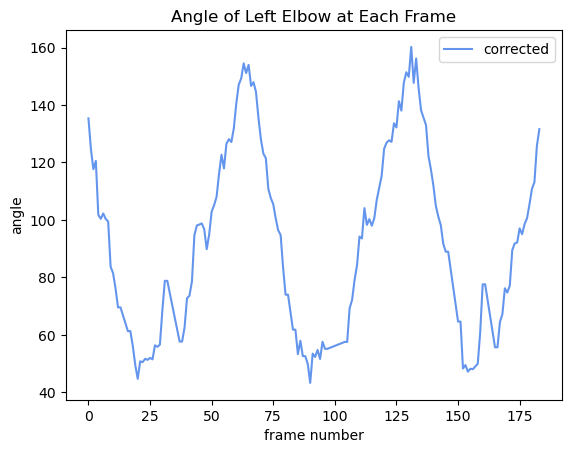

In [17]:
# 8/14/2023
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.legend(['corrected'])

plt.title('Angle of Left Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

### Right elbow

Text(0, 0.5, 'angle')

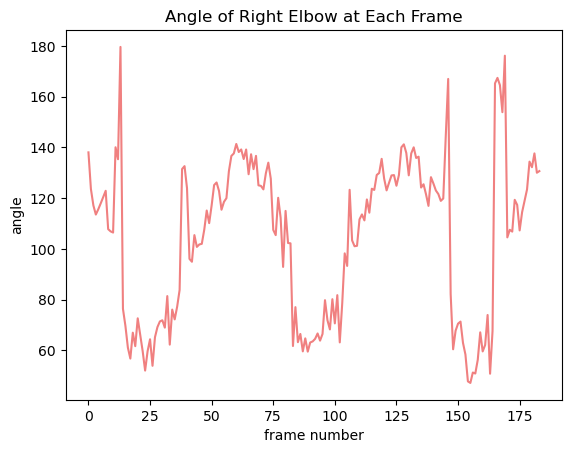

In [18]:
x_axis = range(len(relbow_angles))
plt.plot(x_axis, relbow_angles, color = "lightcoral")

plt.title('Angle of Right Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

In [19]:
normalized_coords = normalization(relbow_angles)

[[10, 41], [74, 78], [79, 82], [82, 105], [105, 108], [144, 171]]


Text(0, 0.5, 'angle')

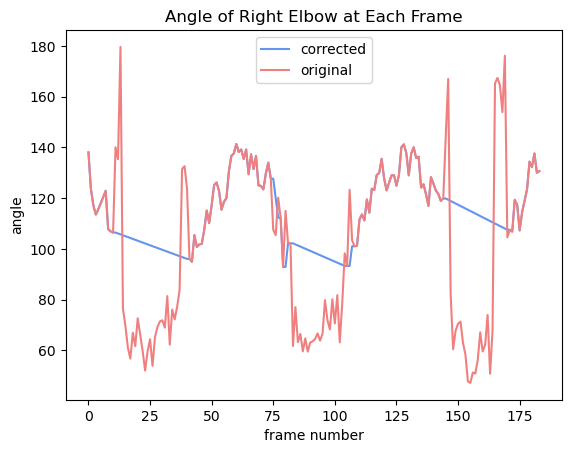

In [20]:
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.plot(x_axis, relbow_angles, color = "lightcoral")
plt.legend(['corrected', 'original'])

plt.title('Angle of Right Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

Text(0, 0.5, 'angle')

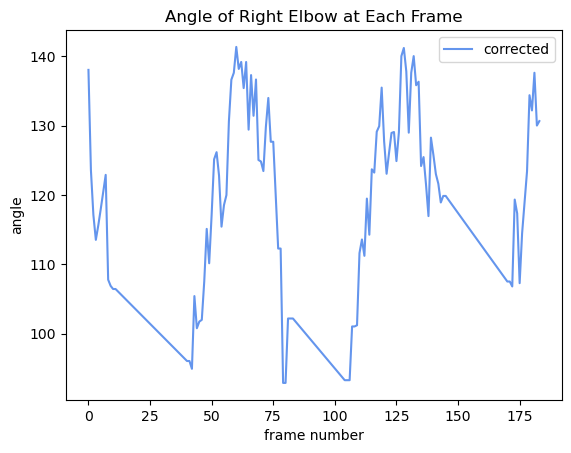

In [21]:
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.legend(['corrected'])

plt.title('Angle of Right Elbow at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

### Left shoulder

Text(0, 0.5, 'angle')

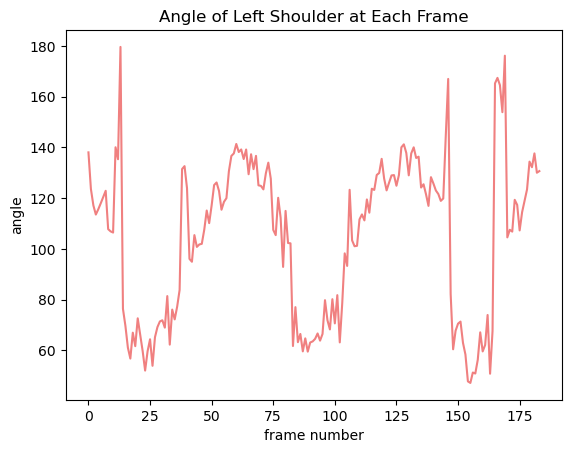

In [36]:
x_axis = range(len(lshoulder_angles))
plt.plot(x_axis, relbow_angles, color = "lightcoral")

plt.title('Angle of Left Shoulder at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

In [40]:
normalized_coords = normalization(lshoulder_angles)

[[12, 39], [82, 86], [98, 101], [103, 111], [146, 163], [164, 171]]


Text(0, 0.5, 'angle')

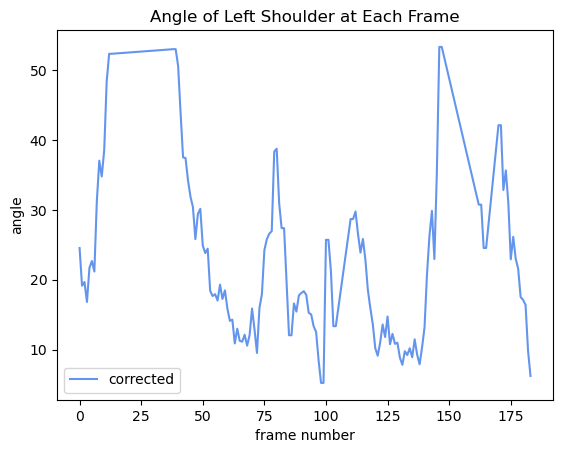

In [41]:
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.legend(['corrected'])

plt.title('Angle of Left Shoulder at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

### Right shoulder

Text(0, 0.5, 'angle')

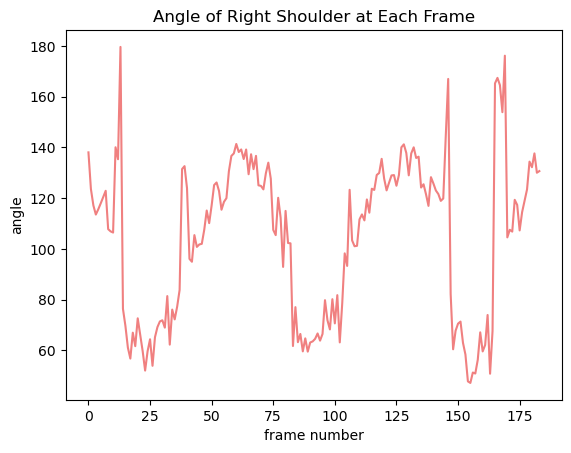

In [37]:
x_axis = range(len(rshoulder_angles))
plt.plot(x_axis, relbow_angles, color = "lightcoral")

plt.title('Angle of Right Shoulder at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

In [42]:
normalized_coords = normalization(rshoulder_angles)

[[83, 92], [164, 167]]


Text(0, 0.5, 'angle')

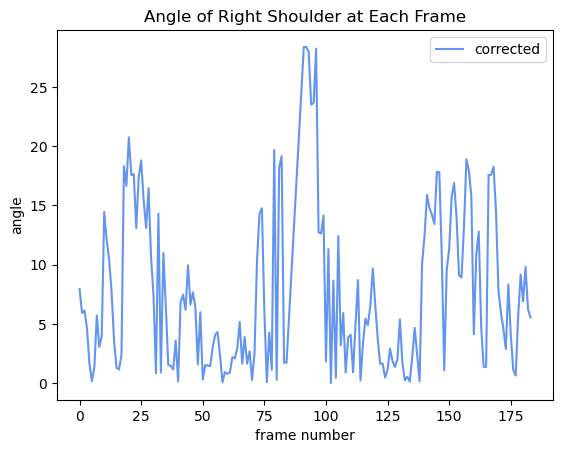

In [43]:
x_axis = range(len(normalized_coords))
plt.plot(x_axis, normalized_coords, color = "cornflowerblue")
plt.legend(['corrected'])

plt.title('Angle of Right Shoulder at Each Frame')
plt.xlabel('frame number')
plt.ylabel('angle')

## 3. Define Movements

<h3>1. Curl</h3>
<div>
    <div class="column">
        <img src="https://i.gifer.com/7hh1.gif" width="400"/>
    </div>
    <div class="column">
        <img src="https://media.tenor.com/JOkZmNENGU0AAAAC/bicep-curl-biceps.gif" width="270"/>
    </div>
</div>

`ifCurl()`

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle repeatedly changes (change more than 60 degrees).

- `wrist` <-- `shoulder` --> `hip` angle almost fixed (change less than 30 degrees).

- Other parts of the body irrelavant.


*Distance:*
`wrists` and `shoulders` getting closer and further, respectively.

*Device:* dumbbells, barbell

In [73]:
# Melody 8/18/2023
def ifCurl(lelbow_angles, relbow_angles, lshoulder_angles, rshoulder_angles):
    
    # Check if the elbow(s) moved
    lelbow_turning_points, relbow_turning_points = get_bend_extend_frames(lelbow_angles, relbow_angles, 30)
    
    # If neither of the elbows moved --> not curl
    if len(lelbow_turning_points) == 0 and len(relbow_turning_points) == 0:
        return 0, 0
    
    # Check if the shoulder(s) moved
    lshoulder_turning_points, rshoulder_turning_points = get_bend_extend_frames(lshoulder_angles, rshoulder_angles, 60)

    if len(lshoulder_turning_points) > 0 or len(rshoulder_turning_points) > 0:
        return 0, 0
    
    # Curl, get how many times
    bend_times = max(len(lelbow_turning_points['bend']), len(relbow_turning_points['bend']))
    extend_times = max(len(lelbow_turning_points['extend']), len(relbow_turning_points['extend']))
    
    return bend_times, extend_times


<div>
    <h3>2. Row</h3>
    <img src="https://hips.hearstapps.com/hmg-prod/images/workouts/2016/03/barbellrow-1457038583.gif" width="400"/>    
</div>

`ifRow()`

*Categories:* single arm, both arms

*Base Pose:*

- standing
- lying (on bench)

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle remains approximately 180 degrees (straight arms, neither bend nor extend)

- `wrist` <-- `shoulder` --> `hip` angle remains approximately 90 degrees.


*Distance:*
`wrists` and `elbows` approximate to 0 and away repeatedly.

*Device:* dumbbells, (bench)

*Palms:* Facing body

In [ ]:
def ifRow():
    pass

<div>
    <h3>3. Press</h3>
    <img src="https://thumbs.gfycat.com/FluffyCarefulBaboon-max-1mb.gif" width="300"/>
</div>

`ifPress()`

*Base Pose:*

- standing
- lying (on bench)

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle from approximately 30 to 180 degrees, repeatedly.

- `wrist` <-- `shoulder` --> `hip` angle from approximately 30 to 180 degrees, repeatedly. The changing rate same with the abovementioned one.


*Distance:*
`wrists` and `elbows` getting closer and further, respectively.

*Device:* dumbbells, (bench)

*Other:* Palms facing front (?)

In [ ]:
def ifPress():
    pass

<h3>4. Fly</h3>
<div>
<img src="https://weighttraining.guide/wp-content/uploads/2016/11/dumbbell-fly-resized.png" align = "center" width="50%"/>
</div>

<div>
    <img src="https://thumbs.gfycat.com/FragrantClosedBettong-max-1mb.gif" align = "left" width="35%"/>
    <img src="https://thumbs.gfycat.com/EverlastingUniformHatchetfish-max-1mb.gif" align = "center" width="35%"/>
</div>

`ifFly()`

*Base Pose:*

- standing
- lying (on bench)

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle remains approximately 180 degrees (straight arms, neither bend nor extend)

- `wrist` <-- `shoulder` --> `hip` angle remains approximately 90 degrees.


*Distance:*
`wrists` and `elbows` approximate to 0 and away repeatedly.

*Device:* dumbbells, (bench)

*Palms:* Facing each other <--> facing forward

In [ ]:
def ifFly():
    pass

<h3>5. Raise</h3>
<div>
<img src="https://weighttraining.guide/wp-content/uploads/2016/10/Dumbbell-Standing-Alternate-Front-Raise-resized.png" align = "center" width="50%"/>
</div>

<div>
    <img src="https://thumbs.gfycat.com/GlaringCaringBuffalo-max-1mb.gif" align = "left" width="35%"/>
    <img src="https://post.healthline.com/wp-content/uploads/2019/11/400x400_Great_Upper_Body_Exercises_for_Women_Dumbbell_Front_Raise.gif" align = "center" width="35%"/>
</div>

`ifRaise()`

*Categories:* front raise

*Base Pose:*

- standing

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle remains approximately 180 degrees (straight arms, neither bend nor extend)

- `wrist` <-- `shoulder` --> `hip` angle remains approximately 90 degrees.


*Distance:*
`wrists` and `elbows` approximate to 0 and away repeatedly.

*Device:* dumbbells, barbell

*Palms:* Facing the ground when raising

In [1]:
def ifRaise():
    pass

<h3>6. Deadlift</h3>
<div>
<img src="https://cdn-0.weighttraining.guide/wp-content/uploads/2016/05/Barbell-Deadlift-1.png?ezimgfmt=ng%3Awebp%2Fngcb4" align = "center" width="50%"/>
</div>

<div>
    <img src="https://hips.hearstapps.com/hmg-prod/images/workouts/2016/03/barbelldeadlift-1457038089.gif" align = "left" width="35%"/>
    <img src="https://i0.wp.com/post.healthline.com/wp-content/uploads/2019/09/400x400_What’s_the_Difference_Between_Deadlifts_and_Squats_and_Which_Is_Better_for_Building_Lower_Body_Strength_Deadlift.gif?w=1155&h=840" align = "center" width="35%"/>
</div>

`ifDeadlift()`

*Categories:* front raise

*Base Pose:*

- standing

*Angles:*

- `wrist` <-- `elbow` --> `shoulder` angle remains approximately 180 degrees (straight arms, neither bend nor extend)

- `wrist` <-- `shoulder` --> `hip` angle remains approximately 90 degrees.


*Distance:*
`wrists` and `elbows` approximate to 0 and away repeatedly.

*Device:* dumbbells, barbell

*Other:* fist palms facing the ground when raising

In [ ]:
def ifDeadlift():
    pass

<div>
    <h3>1. Squat</h3>
    <img src="https://thumbs.gfycat.com/FluffyCarefulBaboon-max-1mb.gif" width="300"/>
</div>

`ifSquat()`

*Base Pose:*

- standing

*Angles:* both legs

- `hip` <-- `knee` --> `ankle` angles of both legs increase (180 degrees at most) and decrease (0 degree at least) repeatedly, simultanously.

In [ ]:
# Return: ifsquat (True or False)
#         lknee_dict (with bend and extend starting and ending frame number)
#         rknee_dict (actually not needed if True)

def ifSquat(lknee_angles, rknee_angles, lshoulder_angles, rshoulder_angles):
    # Check for the left knee, if repeatedly bend and extend.
    lelbow_turning_points, relbow_turning_points = get_bend_extend_frames(lelbow_angles, relbow_angles, 30)


    
    # Check for the right knee, if bend and extend at similar frames as mentioned above.
    
    return ifsquat, lknee_dict, rknee_dict

## 4. Overall workflow

In [74]:
def main(file_path):
    
    movement_description = ""
    
    # 1. Get all the coordinates
    pose_coords = read_movenet_json_file(file_path)
    
    # 2. Get the angles of key joints
    lelbow_angles, relbow_angles, lshoulder_angles, rshoulder_angles, lhip_angles, rhip_angles, lknee_angles, rknee_angles = get_joint_angles(pose_coords) 
    
    # 3. Normalize the angles
    norm_lelbow_angles = normalization(lelbow_angles)
    norm_relbow_angles = normalization(relbow_angles)
    norm_lshoulder_angles = normalization(lshoulder_angles)
    norm_rshoulder_angles = normalization(rshoulder_angles)
    norm_lhip_angles = normalization(lhip_angles)
    norm_rhip_angles = normalization(rhip_angles)
    norm_lknee_angles = normalization(lknee_angles)
    norm_rknee_angles = normalization(rknee_angles)
    
    # 4. Check for each movement
    curl_bend, curl_extend = ifCurl(norm_lelbow_angles, norm_relbow_angles, norm_lshoulder_angles, norm_rshoulder_angles)
    
    if curl_bend > 0 or curl_extend > 0:
        curl_times = max(curl_bend, curl_extend)
        movement_description += "curls " + str(curl_times) + " times."
    
    return movement_description

In [75]:
main(file_path)

[[12, 17], [31, 38], [80, 84], [96, 105], [145, 151], [160, 166]]
[[10, 41], [74, 78], [79, 82], [82, 105], [105, 108], [144, 171]]
[[12, 39], [82, 86], [98, 101], [103, 111], [146, 163], [164, 171]]
[[83, 92], [164, 167]]
[]
[]
[]
[]


'curls 3 times.'

# Backup

In order to tell the directions of hand palms, added left and right `pinky` and `thumb`, to tell the directions using their relative directions. 5/14/2023

In [ ]:
# Process BlazePose generated JSON files
def read_blazepose_json_file(file_path):

    # 1. Load the json file generated by BlazePose, parsed_data is a list of dictionaries
    # with each dictionary as 
    with open(file_path) as data:
        all_data = data.read()

    parsed_data = json.loads(all_data)

    # 2. Create a pandas dataframe with 34 columns (frame_id and 33 key points)
    # Each row representing a frame of the video.
    list_by_keypoints = []
    i = 0
    
    while i < (len(parsed_data)/33):
        frame_dict = []
        
        for j in range(0, 33):
            frame_dict.append(parsed_data[i * 33 + j])
            
        list_by_keypoints.append(frame_dict)
        i += 1
         

    # 3. Add header row to dataframe
    '''
          |frame_id|LShoulder|RShoulder|LElbow|RElbow|LWrist|RWrist|LHip|RHip|LKnee|RKnee|LAnkle|RAnkle|LPinky|RPinky|LThumb|RThumb
    ------------------------------------------------------------------------------------------
    row 0 |  0     | 0.269.  | 0.428   | ...
    ------------------------------------------------------------------------------------------
    row 1 |  1     | ...
    ...
    '''
    
    all_pose_coords = pd.DataFrame(list_by_keypoints, columns = ['Nose', 'LEye_In', 'LEye', 'LEye_Out',
                                                              'REye_In', 'REye', 'REye_Out', 'LEar', 'REar',
                                                              'LMouth', 'RMouth','LShoulder', 'RShoulder', 
                                                              'LElbow', 'RElbow', 'LWrist', 'RWrist',
                                                              'LPinky', 'RPinky', 'LIndex', 'RIndex',
                                                              'LThumb', 'RThumb', 'LHip', 'RHip', 
                                                              'LKnee', 'RKnee', 'LAnkle', 'RAnkle',
                                                              'LHeel', 'RHeel', 'LFoot_Idx', 'RFoot_Idx'])
    
    # 4. Drop irrelevant columns
    # Drop 'Nose', 'LEye_In', 'LEye', 'LEye_Out', 'REye_In', 'REye', 'REye_Out', 'LEar', 'REar', 'LMouth', 'RMouth', 'LPinky', 'RPinky', 'LIndex', 'RIndex', 'LThumb', 'RThumb', 'LHeel', 'RHeel', 'LFoot_Idx', 'RFoot_Idx'
    pose_coords = all_pose_coords.drop(columns = ['Nose', 'LEye_In', 'LEye', 'LEye_Out', 'REye_In', 
                                              'REye', 'REye_Out', 'LEar', 'REar', 
                                              'LMouth', 'RMouth', 'LIndex', 'RIndex', 
                                              'LHeel', 'RHeel', 'LFoot_Idx', 'RFoot_Idx'])
    
    # Add a column for the index of frame (optional)
    # pose_coords.insert(0, 'frame_id', range(0, len(pose_coords))) # 0 - location
    
    
    # 5. Extract the x, y, z of each keypoint
    lshoulder_x, lshoulder_y, lshoulder_z, rshoulder_x, rshoulder_y, rshoulder_z = ([] for i in range(6))
    lelbow_x, lelbow_y, lelbow_z, relbow_x, relbow_y, relbow_z = ([] for i in range(6))
    lwrist_x, lwrist_y, lwrist_z, rwrist_x, rwrist_y, rwrist_z = ([] for i in range(6))
    lhip_x, lhip_y, lhip_z, rhip_x, rhip_y, rhip_z = ([] for i in range(6))
    lknee_x, lknee_y, lknee_z, rknee_x, rknee_y, rknee_z = ([] for i in range(6))
    lankle_x, lankle_y, lankle_z, rankle_x, rankle_y, rankle_z = ([] for i in range(6))
    lpinky_x, lpinky_y, lpinky_z, rpinky_x, rpinky_y, rpinky_z = ([] for i in range(6))
    lthumb_x, lthumb_y, lthumb_z, rthumb_x, rthumb_y, rthumb_z = ([] for i in range(6))

    # Add values of each frame to each list
    # Shoulders
    for each_frame in pose_coords['LShoulder']:
        lshoulder_x.append(each_frame.get("X"))
        lshoulder_y.append(each_frame.get("Y"))
        lshoulder_z.append(each_frame.get("Z"))
    
    
    for each_frame in pose_coords['RShoulder']:    
        rshoulder_x.append(each_frame.get("X"))
        rshoulder_y.append(each_frame.get("Y"))
        rshoulder_z.append(each_frame.get("Z"))
        
    # Elbows
    for each_frame in pose_coords['LElbow']: 
        lelbow_x.append(each_frame.get("X"))
        lelbow_y.append(each_frame.get("Y"))
        lelbow_z.append(each_frame.get("Z"))
    
    for each_frame in pose_coords['RElbow']: 
        relbow_x.append(each_frame.get("X"))
        relbow_y.append(each_frame.get("Y"))
        relbow_z.append(each_frame.get("Z"))

    # Wrists
    for each_frame in pose_coords['LWrist']: 
        lwrist_x.append(each_frame.get("X"))
        lwrist_y.append(each_frame.get("Y"))
        lwrist_z.append(each_frame.get("Z"))

    for each_frame in pose_coords['RWrist']: 
        rwrist_x.append(each_frame.get("X"))
        rwrist_y.append(each_frame.get("Y"))
        rwrist_z.append(each_frame.get("Z"))

    # Hips
    for each_frame in pose_coords['LHip']: 
        lhip_x.append(each_frame.get("X"))
        lhip_y.append(each_frame.get("Y"))
        lhip_z.append(each_frame.get("Z"))
    
    for each_frame in pose_coords['RHip']: 
        rhip_x.append(each_frame.get("X"))
        rhip_y.append(each_frame.get("Y"))
        rhip_z.append(each_frame.get("Z"))

    # Knees
    for each_frame in pose_coords['LKnee']: 
        lknee_x.append(each_frame.get("X"))
        lknee_y.append(each_frame.get("Y"))
        lknee_z.append(each_frame.get("Z"))

    for each_frame in pose_coords['RKnee']: 
        rknee_x.append(each_frame.get("X"))
        rknee_y.append(each_frame.get("Y"))
        rknee_z.append(each_frame.get("Z"))
        
    # Ankles
    for each_frame in pose_coords['LAnkle']: 
        lankle_x.append(each_frame.get("X"))
        lankle_y.append(each_frame.get("Y"))
        lankle_z.append(each_frame.get("Z"))
        
    for each_frame in pose_coords['RAnkle']:         
        rankle_x.append(each_frame.get("X"))
        rankle_y.append(each_frame.get("Y"))
        rankle_z.append(each_frame.get("Z"))
   
    # Fingers
    for each_frame in pose_coords['LPinky']: 
        lpinky_x.append(each_frame.get("X"))
        lpinky_y.append(each_frame.get("Y"))
        lpinky_z.append(each_frame.get("Z"))
        
    for each_frame in pose_coords['RPinky']:         
        rpinky_x.append(each_frame.get("X"))
        rpinky_y.append(each_frame.get("Y"))
        rpinky_z.append(each_frame.get("Z"))
        
    for each_frame in pose_coords['LThumb']: 
        lthumb_x.append(each_frame.get("X"))
        lthumb_y.append(each_frame.get("Y"))
        lthumb_z.append(each_frame.get("Z"))
        
    for each_frame in pose_coords['RThumb']:         
        rthumb_x.append(each_frame.get("X"))
        rthumb_y.append(each_frame.get("Y"))
        rthumb_z.append(each_frame.get("Z"))
    
    # Add each of x, y and z coordinates to the dataframe
    pose_coords['LShoulder_X'] = lshoulder_x
    pose_coords['LShoulder_Y'] = lshoulder_y
    pose_coords['LShoulder_Z'] = lshoulder_z
    
    pose_coords['RShoulder_X'] = rshoulder_x  
    pose_coords['RShoulder_Y'] = rshoulder_y 
    pose_coords['RShoulder_Z'] = rshoulder_z 
    
    pose_coords['LElbow_X'] = lelbow_x
    pose_coords['LElbow_Y'] = lelbow_y
    pose_coords['LElbow_Z'] = lelbow_z
    
    pose_coords['RElbow_X'] = relbow_x
    pose_coords['RElbow_Y'] = relbow_y
    pose_coords['RElbow_Z'] = relbow_z
    
    pose_coords['LWrist_X'] = lwrist_x
    pose_coords['LWrist_Y'] = lwrist_y
    pose_coords['LWrist_Z'] = lwrist_z
    
    pose_coords['RWrist_X'] = rwrist_x
    pose_coords['RWrist_Y'] = rwrist_y
    pose_coords['RWrist_Z'] = rwrist_z
    
    pose_coords['LHip_X'] = lhip_x
    pose_coords['LHip_Y'] = lhip_y
    pose_coords['LHip_Z'] = lhip_z
    
    pose_coords['RHip_X'] = rhip_x 
    pose_coords['RHip_Y'] = rhip_y  
    pose_coords['RHip_Z'] = rhip_z 
    
    pose_coords['LKnee_X'] = lknee_x
    pose_coords['LKnee_Y'] = lknee_y
    pose_coords['LKnee_Z'] = lknee_z
    
    pose_coords['RKnee_X'] = rknee_x
    pose_coords['RKnee_Y'] = rknee_y
    pose_coords['RKnee_Z'] = rknee_z
    
    pose_coords['LAnkle_X'] = lankle_x
    pose_coords['LAnkle_Y'] = lankle_y
    pose_coords['LAnkle_Z'] = lankle_z
    
    pose_coords['RAnkle_X'] = rankle_x  
    pose_coords['RAnkle_Y'] = rankle_y
    pose_coords['RAnkle_Z'] = rankle_z
    
    pose_coords['LPinky_X'] = lpinky_x
    pose_coords['LPinky_Y'] = lpinky_y
    pose_coords['LPinky_Z'] = lpinky_z
    
    pose_coords['RPinky_X'] = rpinky_x  
    pose_coords['RPinky_Y'] = rpinky_y
    pose_coords['RPinky_Z'] = rpinky_z
    
    pose_coords['LThumb_X'] = lthumb_x
    pose_coords['LThumb_Y'] = lthumb_y
    pose_coords['LThumb_Z'] = lthumb_z
    
    pose_coords['RThumb_X'] = rthumb_x
    pose_coords['RThumb_Y'] = rthumb_y
    pose_coords['RThumb_Z'] = rthumb_z
    
    # 6. Drop the original columns
    pose_coords = pose_coords.drop(columns = ['LShoulder', 'RShoulder', 'LElbow', 'RElbow', 'LWrist', 'RWrist',
                                              'LHip', 'RHip', 'LKnee', 'RKnee', 'LAnkle', 'RAnkle', 
                                              'LPinky', 'RPinky', 'LThumb', 'RThumb'])
   
    return pose_coords


# Test the function
pose_coords = read_blazepose_json_file('Body_Pose_Detection/BlazePose/output_json/024_barbell_squat.json')
pose_coords

In [ ]:
# 5/12/2023
def get_joint_angles(pose_coords):
    
    # To store the list of angles (of left and right) at each point of time (by video frame)
    # wrist <- elbow -> shoulder on the same side
    lelbow_angles = []
    relbow_angles = []
    
    # elbow <- shoulder -> hip on the same side
    lshoulder_angles = [] 
    rshoulder_angles = []
    
    # shoulder <- hip -> knee on the same side
    lhip_angles = []
    rhip_angles = []
    
    # hip <- knee -> ankle on the same side
    lknee_angles = []
    rknee_angles = []
    
    # Iterate through each video frame
    for index, row in pose_coords.iterrows():
    
        # Upper body
        lwrist_x = row['LWrist_X']
        lwrist_y = row['LWrist_Y']
        lwrist_z = row['LWrist_Z']
        
        lelbow_x = row['LElbow_X']
        lelbow_y = row['LElbow_Y']
        lelbow_z = row['LElbow_Z']
        
        lshoulder_x = row['LShoulder_X']
        lshoulder_y = row['LShoulder_Y']
        lshoulder_z = row['LShoulder_Z']
        
        rwrist_x = row['RWrist_X']
        rwrist_y = row['RWrist_Y']
        rwrist_z = row['RWrist_Z']

        relbow_x = row['RElbow_X']
        relbow_y = row['RElbow_Y']
        relbow_z = row['RElbow_Z']

        rshoulder_x = row['RShoulder_X']
        rshoulder_y = row['RShoulder_Y']
        rshoulder_z = row['RShoulder_Z']

        # Lower body
        lhip_x = row['LHip_X']
        lhip_y = row['LHip_Y']
        lhip_z = row['LHip_Z']
        
        lknee_x = row['LKnee_X']
        lknee_y = row['LKnee_Y']
        lknee_z = row['LKnee_Z']
        
        lankle_x = row['LAnkle_X']
        lankle_y = row['LAnkle_Y']
        lankle_z = row['LAnkle_Z']
        
        rhip_x = row['RHip_X']
        rhip_y = row['RHip_Y']
        rhip_z = row['RHip_Z']
        
        rknee_x = row['RKnee_X']
        rknee_y = row['RKnee_Y']
        rknee_z = row['RKnee_Z']
        
        rankle_x = row['RAnkle_X']
        rankle_y = row['RAnkle_Y']
        rankle_z = row['RAnkle_Z']

        # Save the angles to lists
        # vector1_head (x, y, z), vector1_tail (x, y, z), vector2_head (x, y, z), vector2_tail (x, y, z)

        # wrist <- elbow -> shoulder
        lelbow_angles.append(three_dim_vectors_angle(lwrist_x, lwrist_y, lwrist_z, 
                                                     lelbow_x, lelbow_y, lelbow_z,
                                                     lshoulder_x, lshoulder_y, lshoulder_z, 
                                                     lelbow_x, lelbow_y, lelbow_z))

        relbow_angles.append(three_dim_vectors_angle(rwrist_x, rwrist_y, rwrist_z, 
                                                     relbow_x, relbow_y, relbow_z,
                                                     rshoulder_x, rshoulder_y, rshoulder_z, 
                                                     relbow_x, relbow_y, relbow_z))

        # elbow <- shoulder -> hip
        lshoulder_angles.append(three_dim_vectors_angle(lelbow_x, lelbow_y, lelbow_z, 
                                                        lshoulder_x, lshoulder_y, lshoulder_z,
                                                        lhip_x, lhip_y, lhip_z, 
                                                        lshoulder_x, lshoulder_y, lshoulder_z))

        rshoulder_angles.append(three_dim_vectors_angle(relbow_x, relbow_y, relbow_z, 
                                                        rshoulder_x, rshoulder_y, rshoulder_z,
                                                        rhip_x, rhip_y, rhip_z, 
                                                        rshoulder_x, rshoulder_y, rshoulder_z))

        # shoulder <- hip -> knee
        lhip_angles.append(three_dim_vectors_angle(lshoulder_x, lshoulder_y, lshoulder_z,
                                                   lhip_x, lhip_y, lhip_z, 
                                                   lknee_x, lknee_y, lknee_z,
                                                   lhip_x, lhip_y, lhip_z))

        rhip_angles.append(three_dim_vectors_angle(rshoulder_x, rshoulder_y, rshoulder_z,
                                                   rhip_x, rhip_y, rhip_z, 
                                                   rknee_x, rknee_y, rknee_z,
                                                   rhip_x, rhip_y, rhip_z))

        # hip <- knee -> ankle
        lknee_angles.append(three_dim_vectors_angle(lhip_x, lhip_y, lhip_z,
                                                    lknee_x, lknee_y, lknee_z,
                                                    lankle_x, lankle_y, lankle_z, 
                                                    lknee_x, lknee_y, lknee_z))

        rknee_angles.append(three_dim_vectors_angle(rhip_x, rhip_y, rhip_z,
                                                    rknee_x, rknee_y, rknee_z,
                                                    rankle_x, rankle_y, rankle_z, 
                                                    rknee_x, rknee_y, rknee_z))
    
    return lelbow_angles, relbow_angles, lshoulder_angles, rshoulder_angles, lhip_angles, rhip_angles, lknee_angles, rknee_angles



`three_dim_vectors_angle(...)`

- Parameters: two 3-dimensional vectors' head and tail's x, y, z coordinates
- Returns: the angle (in degree)

In [ ]:
# 4/14/2023

# In some cases, they might share the same tail
# Reference: https://swdevnotes.com/python/2021/math-3d-vectors-dot-product/
# Latest reference: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

""" Returns the unit vector of the vector.  """
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

""" Returns the angle in radians between vectors 'v1' and 'v2' """
def three_dim_vectors_angle(vec1_head_x, vec1_head_y, vec1_head_z, 
                            vec1_tail_x, vec1_tail_y, vec1_tail_z,
                            vec2_head_x, vec2_head_y, vec2_head_z,
                            vec2_tail_x, vec2_tail_y, vec2_tail_z):
    # Construct vectors
    # Tails of both vectors are the joint point (e.g. elbow)
    vector_1 = [vec1_head_x - vec1_tail_x, vec1_head_y - vec1_tail_y, vec1_head_z - vec1_tail_z]
    vector_2 = [vec2_head_x - vec2_tail_x, vec2_head_y - vec2_tail_y, vec2_head_z - vec2_tail_z]
    
    # Normalize vectors
    v1_u = vector_1 / np.linalg.norm(vector_1)
    v2_u = vector_2 / np.linalg.norm(vector_2)
    
    # Calculate angle
    angle_radian = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
    """Alternatively
    dot_product = np.dot(unit_vec1, unit_vec2)
    angle_radian = np.arccos(dot_product) # Angle in radian
    """
    
    # Convert angle in radian to angle in degree
    angle_degree = angle_radian * 180 / math.pi
    
    return round(angle_degree, 3) # round 3 decimals

# Validate if the function works
# Should return 66.056
print(three_dim_vectors_angle(-3, 4, 3, 
                              0, 0, 0, 
                              -1, 5, -3, 
                              0, 0, 0))

In [ ]:
# Extract the output angles lists
lelbow_coords, relbow_coords, lshoulder_coords, rshoulder_coords, lhip_coords, rhip_coords, lknee_coords, rknee_coords = get_joint_angles(pose_coords)

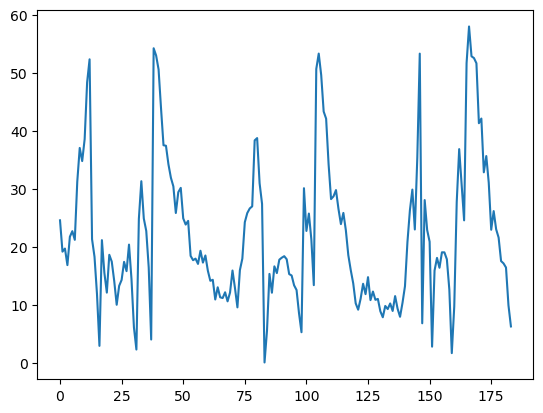

In [24]:
# lshouder
x_axis_lshoulder = [item for item in range(0, len(lshoulder_coords))]
y_axis_lshoulder = lshoulder_coords
plt.plot(x_axis_lshoulder, y_axis_lshoulder)
plt.show()

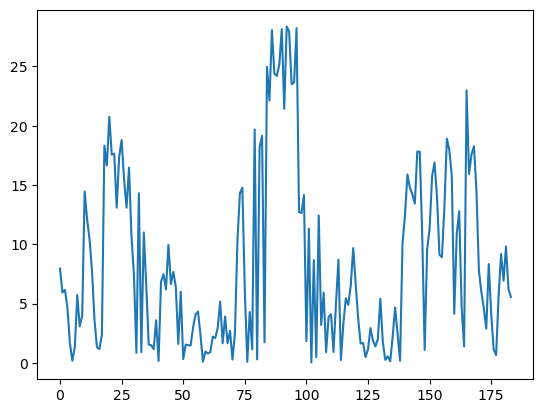

In [25]:
# rshouder
x_axis_rshoulder = [item for item in range(0, len(rshoulder_coords))]
y_axis_rshoulder = rshoulder_coords
plt.plot(x_axis_rshoulder, y_axis_rshoulder)
plt.show()

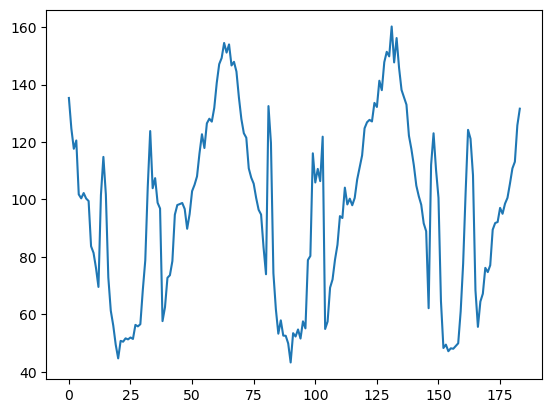

In [33]:
# lelbow
x_axis_lelbow = [item for item in range(0, len(lelbow_coords))]
y_axis_lelbow = lelbow_coords
plt.plot(x_axis_lelbow, y_axis_lelbow)
plt.show()

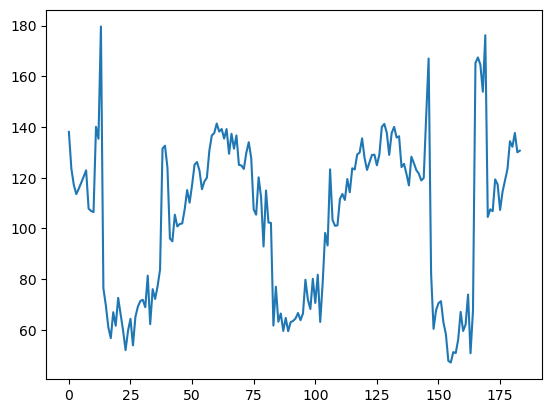

In [34]:
# relbow
x_axis_relbow = [item for item in range(0, len(relbow_coords))]
y_axis_relbow = relbow_coords
plt.plot(x_axis_relbow, y_axis_relbow)
plt.show()

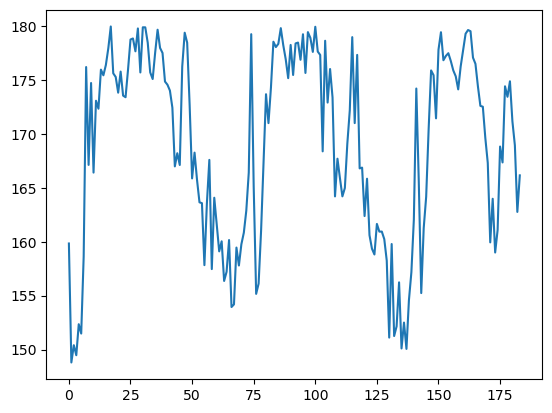

In [28]:
# lhip
x_axis_lhip = [item for item in range(0, len(lhip_coords))]
y_axis_lhip = lhip_coords
plt.plot(x_axis_lhip, y_axis_lhip)
plt.show()

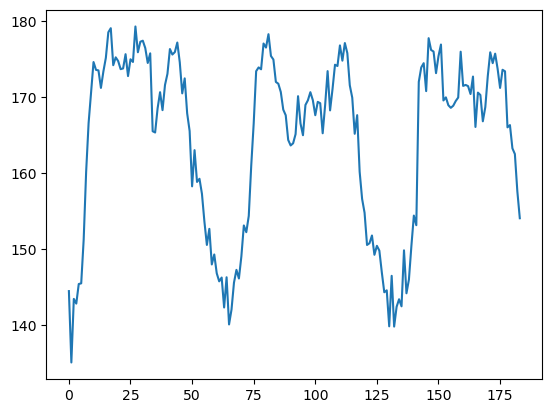

In [29]:
# rhip
x_axis_rhip = [item for item in range(0, len(rhip_coords))]
y_axis_rhip = rhip_coords
plt.plot(x_axis_rhip, y_axis_rhip)
plt.show()

In [ ]:
# lknee
x_axis_lknee = [item for item in range(0, len(lknee_coords))]
y_axis_lknee = lknee_coords
plt.plot(x_axis_lknee, y_axis_lknee)
plt.show()

In [ ]:
# 5/11/2023
# Check the base pose
# Stand, sit, lying, prone (lie on one's stomach)
# Returns
def get_pose():
    return pose_dict

In [ ]:
# 5/11/2023
# Currently supports 7 arm movements
# curl, row, press, fly, shrug (shoulder), raise, deadlift
def get_arm_movements(larm, rarm, lshouder, rshoulder):
    return False

5/14/2023

The `palm_facing_directions` are determined by the relative directions of thumb and pinky of each hand. 
It falls into the below categories, regardless of fists or opened hands:
- facing backward (body)
    - left hand: `lpinky_x - lthumb_x` share the same plus/minus sign with `rshoulder_x - lshoulder_x`. 
    - right hand: `rthumb_x - rpinky_x` share the same plus/minus sign with `rshoulder_x - lshoulder_x`. 
- facing forward (front)
    - left hand: `lthumb_x - lpinky_x` share the same plus/minus sign with `rshoulder_x - lshoulder_x`. 
    - right hand: `rpinky_x - rthumb_x` share the same plus/minus sign with `rshoulder_x - lshoulder_x`. 
- facing inward (on sides, facing body)
- facing outward (on sides, facing on the opposite directions)
- facing down (ground)
- facing up (sky)

The only frames concerned are the turning points and 3 frames afterwards (except for the last frame). This requires the bending and extending movements of elbows or shoulders.

`get_coords_lists`

e.g. `lshoulder_coords` is 

`[[frame_1_x, frame_1_y, frame_1_z],`

`[frame_2_x, frame_2_y, frame_2_z],`

`...`

`[frame_n_x, frame_n_y, frame_n_z]]`

In [ ]:
'''
'LShoulder', 'RShoulder', 'LElbow', 'RElbow', 'LWrist', 'RWrist',
'LHip', 'RHip', 'LKnee', 'RKnee', 'LAnkle', 'RAnkle', 
'LPinky', 'RPinky', 'LThumb', 'RThumb'
'''

def get_coords_lists(pose_coords):
    for index, row in pose_coords.iterrows():
        # 1. Shoulders
        lshoulder_x = row['LShoulder_X']
        lshoulder_y = row['LShoulder_Y']
        lshoulder_z = row['LShoulder_Z']
            
        rshoulder_x = row['RShoulder_X']
        rshoulder_y = row['RShoulder_Y']
        rshoulder_z = row['RShoulder_Z']
        
        # 2. Elbows
        lelbow_x = row['LElbow_X']
        lelbow_y = row['LElbow_Y']
        lelbow_z = row['LElbow_Z']
        
        relbow_x = row['RElbow_X']
        relbow_y = row['RElbow_Y']
        relbow_z = row['RElbow_Z']
        
        # 3. Wrists
        lwrist_x = row['LWrist_X']
        lwrist_y = row['LWrist_Y']
        lwrist_z = row['LWrist_Z']

        rwrist_x = row['RWrist_X']
        rwrist_y = row['RWrist_Y']
        rwrist_z = row['RWrist_Z']
        
        # 4. Hips
        
        # 5. Knees
        
        # 6. Ankles
        
        # 7. Pinkies
        
        # 8. Thumbs
        

        

        
        lshoulder_x = row['LShoulder_X']
        lshoulder_y = row['LShoulder_Y']
        lshoulder_z = row['LShoulder_Z']
        



        rshoulder_x = row['RShoulder_X']
        rshoulder_y = row['RShoulder_Y']
        rshoulder_z = row['RShoulder_Z']

        # Lower body
        lhip_x = row['LHip_X']
        lhip_y = row['LHip_Y']
        lhip_z = row['LHip_Z']
        
        lknee_x = row['LKnee_X']
        lknee_y = row['LKnee_Y']
        lknee_z = row['LKnee_Z']
        
        lankle_x = row['LAnkle_X']
        lankle_y = row['LAnkle_Y']
        lankle_z = row['LAnkle_Z']
        
        rhip_x = row['RHip_X']
        rhip_y = row['RHip_Y']
        rhip_z = row['RHip_Z']
        
        rknee_x = row['RKnee_X']
        rknee_y = row['RKnee_Y']
        rknee_z = row['RKnee_Z']
        
        rankle_x = row['RAnkle_X']
        rankle_y = row['RAnkle_Y']
        rankle_z = row['RAnkle_Z']
        

        lpinky_x = pose_coords['LPinky_X']
        rpinky_x = pose_coords['RPinky_X']
        lthumb_x = pose_coords['LThumb_X']
        rthumb_x = pose_coords['RThumb_X']
    return lshoulder_coords, rshoulder_coords, lelbow_coords, relbow_coords, lwrist_coords, rwrist_coords,
lhip_coords, rhip_coords, lknee_coords, rknee_coords, lankle_coords, rankle_coords, 
lpinky_coords, rpinky_coords, lthumb_coords, rthumb_coords

In [ ]:
def main(file_path):
    # 1. Convert the json generated by BlazePose to a dataframe of coordinations of all related key points
    pose_coords = read_blazepose_json_file(file_path)
    
    # 2. Extract the x, y, z of all key point to a list

In [ ]:
# 5/14/2023
# Separate for left and right hands
def palms_facing_directions(pose_coords):
    
    # 之后统一一个function，比如叫get_coodrs_list，一次性取出所有list。
    for index, row in pose_coords.iterrows():
        lshoulder_x = pose_coords['LShoulder_X']
        rshoulder_x = pose_coords['RShoulder_X']
        lpinky_x = pose_coords['LPinky_X']
        rpinky_x = pose_coords['RPinky_X']
        lthumb_x = pose_coords['LThumb_X']
        rthumb_x = pose_coords['RThumb_X']
    
    i = 19
    
    '''
    forward
    '''
    # left hand
    if (lthumb_x[i] - lpinky_x[i]) > 0 and (rshoulder_x[i] - lshoulder_x[i]) > 0:
        lpalm_forward = True
    elif (lthumb_x[i] - lpinky_x[i]) < 0 and (rshoulder_x[i] - lshoulder_x[i]) < 0:
        lpalm_forward = True
    else:
        lpalm_forward = False
    
    if lpalm_forward == True:
        '''
        down
        '''
        #lpalm_forward = False;
        
    # right hand
    if (rpinky_x[i] - rthumb_x[i]) > 0 and (rshoulder_x[i] - lshoulder_x[i]) > 0:
        rpalm_forward = True
    elif (rpinky_x[i] - rthumb_x[i]) < 0 and (rshoulder_x[i] - lshoulder_x[i]) < 0:
        rpalm_forward = True
    else:
        rpalm_forward = False
    

    '''
    backward
    '''
    # left hand
    if (lpinky_x[i] - lthumb_x[i]) > 0 and (rshoulder_x[i] - lshoulder_x[i]) > 0:
        lpalm_backward = True
    elif (rpinky_x[i] - rthumb_x[i]) < 0 and (rshoulder_x[i] - lshoulder_x[i]) < 0:
        lpalm_backward = True
    else:
        lpalm_backward = False
    
    # right hand
    if (rthumb_x[i] - rpinky_x[i]) > 0 and (rshoulder_x[i] - lshoulder_x[i]) > 0:
        rpalm_backward = True
    elif (rthumb_x[i] - rpinky_x[i]) < 0 and (rshoulder_x[i] - lshoulder_x[i]) < 0:
        rpalm_backward = True
    else:
        rpalm_backward = False
    

        
    '''
    inward
    '''
    # right hand
    
    # left hand
    
    
    '''
    outward
    '''
    # right hand
    
    # left hand
    
    
    '''
    up
    '''
    # right hand
    
    # left hand
    

    
    return lpalm_forward, rpalm_forward, lpalm_backward, rpalm_backward

lpalm_forward, rpalm_forward, lpalm_backward, rpalm_backward = palms_facing_directions(pose_coords)

print(lpalm_forward)
print(rpalm_forward)
print(lpalm_backward)
print(rpalm_backward)

**8/14/2023**

As suggested by Prof. Reza, I could apply [moving average](https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/).

In [ ]:
# Melody 8/14/2023

def moving_average(angles_list, window_size):
    
    moving_averages = []
    
    i = 0
    
    while i < len(angles_list) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = angles_list[i : i + window_size]
        
        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1
        
    return moving_averages

In [ ]:
# Melody-8/9/2023
# Smoothing the curve
# https://tedboy.github.io/scipy/generated/scipy.signal.savgol_filter.html

from scipy import signal

def savitzky_golay_filter(data):
    data_smooth = signal.savgol_filter(data, window_length=5, polyorder=3, mode="nearest")
    return data_smooth

In [ ]:
# Melody-8/9/2023
# Defines the change threshold as 10% of the "before" length
# Returns True if length change > 10% of previous length; False if not
def length_change(x1_before, y1_before, x2_before, y2_before,
                  x1_after, y1_after, x2_after, y2_after):
    
    length_before = get_length(x1_before, y1_before, x2_before, y2_before)
    length_after = get_length(x1_after, y1_after, x2_after, y2_after)
    
    return length_before
    #return (np.abs(length_after - length_before) / length_before) > (length_before * 0.3)

In [ ]:
length_changes_shoulder_elbow = []
length_changes_wrist_elbow = []

for idx in range(len(lelbow_x) - 2):
    length_changes_shoulder_elbow.append(length_change(lshoulder_x[idx], lshoulder_y[idx], 
                                        lelbow_x[idx], lelbow_y[idx], 
                                        lshoulder_x[idx+2], lshoulder_y[idx+2],
                                        lelbow_x[idx+2], lelbow_y[idx+2]))
    
    length_changes_wrist_elbow.append(length_change(lwrist_x[idx], lwrist_y[idx], 
                                        lelbow_x[idx], lelbow_y[idx], 
                                        lwrist_x[idx+2], lwrist_y[idx+2],
                                        lelbow_x[idx+2], lelbow_y[idx+2]))


x = range(len(length_changes_shoulder_elbow))
plot(x, length_changes_shoulder_elbow)